# Neural network for predicting the last word in a sentence

Adapted (without permission!) from Octave code from programming assignment 2 from Coursera course [Neural Networks for Machine Learning](https://www.coursera.org/learn/neural-networks/) by Geoff Hinton

## Step 1

Read data stored in matlab binary file format file _sentence_data.mat_ and look at some of the data cases.

In [1]:
import numpy as np

def load_data(filename = 'sentence_data.mat', N = 100):
    '''Load the data set (training, validation and test partitions) and divide it into mini-batches

    Args:
        filename:       string, matlab binary format data file
        N:              integer, mini-batch size

    Returns:
        train_input:    array of size D x N x M, where
            D: number of input dimensions (3)
            N: size of each mini-batch
            M: number of mini-batches

        train_target:   array of size N x M
        valid_input:    array of size D x number of points in validation set
        test:           array of size D x number of points in test set

        vocab: vocabulary containing index to word mapping
    '''
    import scipy.io
    datafile = scipy.io.loadmat(filename)

    train = datafile['data']['trainData'][0][0]
    # shift all entries by 1 (python arrays zero-based!)
    train = train - np.ones(train.shape, dtype=int)
    numdims = len(train)
    D = numdims - 1 
    M = len(train[0]) / N 

    train = train[:,:M*N]
    train.shape = [numdims, N, M]

    train_input = train[:D,:,:]
    train_target = train[D,:,:]

    valid = datafile['data']['validData'][0][0]
    # shift all entries by 1 (python arrays zero-based!)
    valid = valid - np.ones(valid.shape, dtype=int)
    valid_input = valid[:D,:]
    valid_target = valid[D,:]
    valid_target.shape = [1,len(valid_target)]

    test = datafile['data']['testData'][0][0]
    # shift all entries by 1 (python arrays zero-based!)
    test = test - np.ones(test.shape, dtype=int)
    test_input = test[:D,:]
    test_target = test[D,:]
    test_target.shape = [1,len(test_target)]

    vocab = np.array([s[0] for s in datafile['data']['vocab'][0][0][0,:]])

    return train_input, train_target, valid_input, valid_target, test_input, test_target, vocab

In [2]:
# read data into training set (divided into batches), validation set and testing set
#     vocab is a list of all the words in the vocabulary
#     ??_input array contain the indices in vocab of the first three words in a sentence
#     ??_target array contain the index of the fourth word in the corresponding sentence

train_input, train_target, valid_input, valid_target, test_input, test_target, vocab = load_data('sentence_data.mat', 100)

# first ten 'sentences' in first training batch:
for i in range(10):
    print('%s %s %s %s' % tuple(vocab[np.concatenate((train_input[:,0,i],[train_target[0,i]]))]))


going to be .
were not the first
can do for each
first time in my
nt have the money
know what to do
i do nt do
nt do that .
what do you do
know is we are


## Step 2

Method to propagate input forward through network

Network consists of:
- input layer: vocab indices of the first three words in the sentence
- word embedding layer: vector representations of each input word
- hidden layer: logistic hidden layer
- output layer: softmax layer representing the probabilities of each word in vocab being last word in sentence

Weight matrices:
- word_embedding_weights: vocab_size x embedding_vector_length
- embed_to_hidden_weights: 3 * embedding_vector_length x num_hidden_layer_nodes
- hidden_to_output_weights: num_hidden_layer_nodes x vocab_size

In [3]:
def fprop(input_batch, word_embedding_weights, embed_to_hid_weights, \
          hid_to_output_weights, hid_bias, output_bias):
    '''This method forward propagates through a neural network.
    
    Args:
       input_batch: The input data as a matrix of size numwords X batchsize where,
                    numwords is the number of words, batchsize is the number of data points.
                    So, if input_batch(i, j) = k then the ith word in data point j is word
                    index k of the vocabulary.
    
       word_embedding_weights: Word embedding as a matrix of size
                    vocab_size X numhid1, where vocab_size is the size of the vocabulary
                    numhid1 is the dimensionality of the embedding space.
    
       embed_to_hid_weights: Weights between the word embedding layer and hidden
                    layer as a matrix of soze numhid1*numwords X numhid2, numhid2 is the
                    number of hidden units.
     
       hid_to_output_weights: Weights between the hidden layer and output softmax
                    unit as a matrix of size numhid2 X vocab_size
    
       hid_bias: Bias of the hidden layer as a matrix of size numhid2 X 1.
    
       output_bias: Bias of the output layer as a matrix of size vocab_size X 1.
    
    Returns:
       embedding_layer_state: State of units in the embedding layer as a matrix of
                    size numhid1*numwords X batchsize
    
       hidden_layer_state: State of units in the hidden layer as a matrix of size
                    numhid2 X batchsize
    
       output_layer_state: State of units in the output layer as a matrix of size
                    vocab_size X batchsize
    '''
    # array dimensions
    numwords, batchsize = input_batch.shape
    vocab_size, numhid1 = word_embedding_weights.shape
    numhid2 = embed_to_hid_weights.shape[1]

    ### Compute state of word embedding layer:
    # look up the input word indices in the word_embedding_weights matrix:
    embedding_layer_state = np.reshape( \
             word_embedding_weights[np.reshape(input_batch, (1, -1)),:].transpose(), (numhid1 * numwords, -1))

    ### Compute state of hidden layer:
    # compute inputs to hidden units:
    inputs_to_hidden_units = embed_to_hid_weights.transpose().dot(embedding_layer_state) + \
                             np.repeat(hid_bias, batchsize, 1)
    # apply logistic activation function:
    hidden_layer_state = 1 / (1 + np.exp(-inputs_to_hidden_units))

    ### Compute state of output layer:
    # compute inputs to softmax:
    inputs_to_softmax = hid_to_output_weights.transpose().dot(hidden_layer_state) + \
                            np.repeat(output_bias, batchsize, 1)
    # subtract maximum: 
    #.. Remember that adding or subtracting the same constant from each input to a
    #.. softmax unit does not affect the outputs. Here we are subtracting maximum to
    #.. make all inputs <= 0. This prevents overflows when computing their
    #.. exponents.
    inputs_to_softmax = inputs_to_softmax - np.max(inputs_to_softmax,0)
    # compute exp:
    output_layer_state = np.exp(inputs_to_softmax)
    # normalize to get probability distribution (softmax output):
    output_layer_state = output_layer_state / np.repeat( \
                                np.sum(output_layer_state, 0, keepdims=True), vocab_size, 0)

    return embedding_layer_state, hidden_layer_state, output_layer_state
    

## Step 3

Train the model using back propagation and cross-entropy loss function.

In [4]:
import time

def train(epochs, batchsize = 100, learning_rate = 0.1, \
          momentum = 0.9, numhid1 = 50, numhid2 = 200, init_wt = 0.01):
    '''Train a neural network language model

    Args:
        epochs:         number of epochs to run
        batchsize:      mini-batch size
        learning_rate:  step size for gradient descent
        momentum:       gradient-descent momentum parameter
        numhid1:        number of nodes in first hidden layer
        numhid2:        number of nodes in second hidden layer
        init_wt:        amplitude of initial weights

    Returns:
        model:  object containing the learned weights, biases and vocabulary
    '''
    # frequency of updating training progress
    show_training_CE_after = 400
    show_validation_CE_after = 1200

    # load data
    train_input, train_target, \
            valid_input, valid_target, \
            test_input, test_target, \
            vocab = load_data('sentence_data.mat', batchsize)

    numwords, batchsize, numbatches = train_input.shape
    print('training ... %d batches of size %d' % (numbatches, batchsize))
    vocab_size = len(vocab)

    # initialize weights and biases
    ran_seed = 666
    ran_state = np.random.RandomState(seed = ran_seed)

    word_embedding_weights = ran_state.normal(0.0, init_wt, (vocab_size, numhid1))
    embed_to_hid_weights = ran_state.normal(0.0, init_wt, (numwords * numhid1, numhid2))
    hid_to_output_weights = ran_state.normal(0.0, init_wt, (numhid2, vocab_size))

    hid_bias = np.zeros((numhid2, 1))
    output_bias = np.zeros((vocab_size, 1))

    # empty arrays for back-propagation 
    word_embedding_weights_delta = np.zeros((vocab_size, numhid1))
    word_embedding_weights_gradient = np.zeros((vocab_size, numhid1))
    embed_to_hid_weights_delta = np.zeros((numwords * numhid1, numhid2))
    hid_to_output_weights_delta = np.zeros((numhid2, vocab_size))
    hid_bias_delta = np.zeros((numhid2, 1))
    output_bias_delta = np.zeros((vocab_size, 1))
    expansion_matrix = np.eye(vocab_size)

    count = 0;
    tiny = np.exp(-30.);

    # start training!
    start_time = time.time()
    for epoch in xrange(epochs):
        print('\nEpoch %d' % (epoch))
        this_chunk_CE = 0
        trainset_CE = 0

        for m in xrange(numbatches):
            input_batch = train_input[:,:,m]
            target_batch = train_target[:,m]

            # forward propagate:
            #   compute state of each layer in network given the input batch
            #   and all weights and biases
            embedding_layer_state, hidden_layer_state, output_layer_state = \
                    fprop(input_batch, \
                          word_embedding_weights, embed_to_hid_weights, \
                          hid_to_output_weights, hid_bias, output_bias)

            # compute derivative:
            ## Expand the target to a sparse 1-of-K vector.
            expanded_target_batch = expansion_matrix[:, target_batch]
            ## Compute derivative of cross-entropy loss function.
            error_deriv = output_layer_state - expanded_target_batch

            # Compute loss function:
            CE = -sum(sum(expanded_target_batch * np.log(output_layer_state + tiny))) / batchsize;
            count += 1
            this_chunk_CE = this_chunk_CE + (CE - this_chunk_CE) / count
            trainset_CE = trainset_CE + (CE - trainset_CE) / (m+1)
            if np.mod(m+1, show_training_CE_after) == 0:
                print('Batch %d Train CE %.3f' % (m+1, this_chunk_CE))
                count = 0
                this_chunk_CE = 0

            # Back propagate:
            ## output layer
            hid_to_output_weights_gradient =  hidden_layer_state.dot(error_deriv.transpose())
            output_bias_gradient = np.sum(error_deriv, 1, keepdims=True)
            back_propagated_deriv_1 = (hid_to_output_weights.dot(error_deriv)) \
                                   * hidden_layer_state * (1 - hidden_layer_state)

            ## hidden layer
            embed_to_hid_weights_gradient = embedding_layer_state.dot(back_propagated_deriv_1.transpose())
            hid_bias_gradient = np.sum(back_propagated_deriv_1, 1, keepdims=True)
            back_propagated_deriv_2 = embed_to_hid_weights.dot(back_propagated_deriv_1)


            word_embedding_weights_gradient = np.zeros((vocab_size, numhid1))
            ## embedding layer
            for w in xrange(numwords):
                word_embedding_weights_gradient = word_embedding_weights_gradient + \
                     expansion_matrix[:, input_batch[w, :]].dot(( \
                                 back_propagated_deriv_2[w*numhid1 : (w+1)*numhid1, :].transpose()))
                    
            ## update weights and biases
            word_embedding_weights_delta = momentum * word_embedding_weights_delta + \
                                             word_embedding_weights_gradient / batchsize
            word_embedding_weights = word_embedding_weights - \
                                             learning_rate * word_embedding_weights_delta

            embed_to_hid_weights_delta = momentum * embed_to_hid_weights_delta + \
                                             embed_to_hid_weights_gradient / batchsize
            embed_to_hid_weights = embed_to_hid_weights - learning_rate * embed_to_hid_weights_delta

            hid_to_output_weights_delta = momentum * hid_to_output_weights_delta + \
                                             hid_to_output_weights_gradient / batchsize
            hid_to_output_weights = hid_to_output_weights - learning_rate * hid_to_output_weights_delta

            hid_bias_delta = momentum * hid_bias_delta + hid_bias_gradient / batchsize
            hid_bias = hid_bias - learning_rate * hid_bias_delta

            output_bias_delta = momentum * output_bias_delta + output_bias_gradient / batchsize
            output_bias = output_bias - learning_rate * output_bias_delta;

            # Validate:
            if np.mod(m+1, show_validation_CE_after) == 0:
                print('  Running validation ...')
                embedding_layer_state, hidden_layer_state, output_layer_state = \
                        fprop(valid_input, word_embedding_weights, embed_to_hid_weights, \
                              hid_to_output_weights, hid_bias, output_bias)
                datasetsize = valid_input.shape[1]
                expanded_valid_target = expansion_matrix[:, valid_target]
                CE = -np.sum(np.sum(np.squeeze(expanded_valid_target) * \
                                           np.log(output_layer_state + tiny))) / datasetsize
                print('  Validation CE %.3f' % (CE))

        print('Average Training CE %.3f' % (trainset_CE))

    print('\nFinished Training.');
    print('Final Training CE %.3f\n' % (trainset_CE))

    # Evaluate on validation set:
    print('Running validation ...')
    embedding_layer_state, hidden_layer_state, output_layer_state = \
            fprop(valid_input, word_embedding_weights, embed_to_hid_weights, \
                  hid_to_output_weights, hid_bias, output_bias)
    datasetsize = valid_input.shape[1]
    expanded_valid_target = expansion_matrix[:, valid_target]
    CE = -np.sum(np.sum(np.squeeze(expanded_valid_target) * \
                               np.log(output_layer_state + tiny))) / datasetsize
    print('Final Validation CE %.3f\n' % (CE))
                    
    # Evaluate on test set:
    print('Running test ...')
    embedding_layer_state, hidden_layer_state, output_layer_state = \
            fprop(test_input, word_embedding_weights, embed_to_hid_weights, \
                  hid_to_output_weights, hid_bias, output_bias)
    datasetsize = test_input.shape[1]
    expanded_test_target = expansion_matrix[:, test_target]
    CE = -np.sum(np.sum(np.squeeze(expanded_test_target) * \
                               np.log(output_layer_state + tiny))) / datasetsize
    print('Final Test CE %.3f' % (CE))

    model = {}
    model['word_embedding_weights'] = word_embedding_weights
    model['embed_to_hid_weights'] = embed_to_hid_weights
    model['hid_to_output_weights'] = hid_to_output_weights
    model['hid_bias'] = hid_bias
    model['output_bias'] = output_bias
    model['vocab'] = vocab

    time_diff = time.time() - start_time
    print('\n   Training took %.2f seconds!!' % (time_diff))

    return model                

In [5]:
# train a model with default parameters for 10 epochs (passes through training set)

model = train(10)

training ... 3725 batches of size 100

Epoch 0
Batch 400 Train CE 4.504
Batch 800 Train CE 4.465
Batch 1200 Train CE 4.426
  Running validation ...
  Validation CE 4.409
Batch 1600 Train CE 4.260
Batch 2000 Train CE 4.057
Batch 2400 Train CE 3.918
  Running validation ...
  Validation CE 3.793
Batch 2800 Train CE 3.662
Batch 3200 Train CE 3.487
Batch 3600 Train CE 3.385
  Running validation ...
  Validation CE 3.343
Average Training CE 3.995

Epoch 1
Batch 400 Train CE 2.475
Batch 800 Train CE 3.195
Batch 1200 Train CE 3.150
  Running validation ...
  Validation CE 3.132
Batch 1600 Train CE 3.125
Batch 2000 Train CE 3.083
Batch 2400 Train CE 3.056
  Running validation ...
  Validation CE 3.034
Batch 2800 Train CE 3.005
Batch 3200 Train CE 2.987
Batch 3600 Train CE 2.967
  Running validation ...
  Validation CE 2.958
Average Training CE 3.086

Epoch 2
Batch 400 Train CE 2.223
Batch 800 Train CE 2.904
Batch 1200 Train CE 2.899
  Running validation ...
  Validation CE 2.894
Batch 1600 Tra

## Step 4

Look at some predictions in test set

In [6]:
def predict_next_word(words, model, k, display=True):
    '''Predicts the next word

    Args:
        words: iterable of first three words in sentence
        model: Model returned by the training script.
        k: The k most probable predictions are shown.

    Returns:
        The k most probable words predicted and their probabilities

    Example usage:
        predict_next_word(('john', 'might', 'be'), model, 3)
        predict_next_word(('life', 'in', 'new'), model, 3)
    '''

    word_embedding_weights = model['word_embedding_weights']
    vocab = list(model['vocab'])
    inputs = np.reshape(np.array([vocab.index(w) for w in words]), [3,1])
    
    embedding_layer_state, hidden_layer_state, output_layer_state = \
            fprop(inputs, model['word_embedding_weights'], model['embed_to_hid_weights'], \
                  model['hid_to_output_weights'], model['hid_bias'], model['output_bias'])

    probabilities = sorted(zip(output_layer_state, model['vocab']), key = lambda x: -x[0])
    if display:
        for prob in probabilities[:k]:
            print('\t%s %s %s .. %s \t( p = %.3f )' % (words[0], words[1], words[2], prob[1], prob[0][0]))

    return [(prob[1],prob[0][0]) for prob in probabilities[:k]]


In [7]:
# first five 'sentences' in test set:
for i in range(5):
    print('=================')
    print('Test sentence %d:' % (i))
    predictions = predict_next_word(vocab[test_input[:,i]], model, 5, display = True)
    print('')
    print('Correct: " %s %s %s %s "' % tuple(vocab[np.concatenate((test_input[:,i],[test_target[0,i]]))]))
    print('')


Test sentence 0:
	can be called .. . 	( p = 0.345 )
	can be called .. ? 	( p = 0.140 )
	can be called .. in 	( p = 0.051 )
	can be called .. for 	( p = 0.050 )
	can be called .. , 	( p = 0.046 )

Correct: " can be called . "

Test sentence 1:
	they are well .. . 	( p = 0.307 )
	they are well .. on 	( p = 0.089 )
	they are well .. , 	( p = 0.067 )
	they are well .. in 	( p = 0.052 )
	they are well .. for 	( p = 0.039 )

Correct: " they are well , "

Test sentence 2:
	are well , .. he 	( p = 0.145 )
	are well , .. you 	( p = 0.090 )
	are well , .. but 	( p = 0.086 )
	are well , .. she 	( p = 0.079 )
	are well , .. i 	( p = 0.079 )

Correct: " are well , she "

Test sentence 3:
	well , she .. said 	( p = 0.354 )
	well , she .. did 	( p = 0.241 )
	well , she .. was 	( p = 0.057 )
	well , she .. 's 	( p = 0.046 )
	well , she .. does 	( p = 0.045 )

Correct: " well , she said "

Test sentence 4:
	, she said .. . 	( p = 0.934 )
	, she said .. , 	( p = 0.047 )
	, she said .. yesterday 	( p = 0

## Step 5

Calculate the closest words in embedding space to a given word

In [8]:
def display_nearest_words(word, model, k):
    '''Shows the k nearest words to the query word.

    Args:
        word: The query word as a string.
        model: Model returned by the training script.
        k: The number of nearest words to display.
        
    Returns:
        The k nearest words and their distances in embedding space

    Example usage:
        display_nearest_words('school', model, 10)
    '''

    word_embedding_weights = model['word_embedding_weights']
    vocab = list(model['vocab'])
    word_id = vocab.index(word)

    #Compute distance to every other word.
    vocab_size = len(vocab)
    word_embedding = word_embedding_weights[word_id]
    distances = [np.sqrt(np.sum((me - them[i])**2 for i,me in enumerate(word_embedding))) \
                                                            for them in word_embedding_weights]
    return sorted(zip(vocab, distances), key = lambda x: x[1])[1:k+1]

In [9]:
test_word_list = ['she', 'man', 'could', 'next', 'city', 'up']
print 'test_word\tneighbour (distance)'
print '=========\t====================='
for word in test_word_list:
    nearest = display_nearest_words(word, model, 6)
    for i,neighbour in enumerate(nearest):
        if i:
            word_or_nothing = ''
        else:
            word_or_nothing = word
        print('%s\t\t%s  (%.3f)' % (word_or_nothing, neighbour[0], neighbour[1]))
    print('')

test_word	neighbour (distance)
=========	=====================
she		he  (4.443)
		west  (4.505)
		women  (4.576)
		officials  (4.685)
		they  (4.715)
		john  (4.716)

man		country  (3.510)
		west  (3.579)
		director  (3.586)
		women  (3.664)
		court  (3.676)
		office  (3.729)

could		companies  (4.930)
		officials  (4.965)
		would  (5.054)
		before  (5.171)
		state  (5.250)
		)  (5.295)

next		second  (4.251)
		department  (4.302)
		every  (4.332)
		university  (4.465)
		former  (4.467)
		public  (4.473)

city		university  (2.475)
		former  (2.517)
		members  (2.545)
		state  (2.547)
		percent  (2.549)
		)  (2.561)

up		four  (4.529)
		down  (4.570)
		percent  (4.630)
		state  (4.684)
		ms.  (4.689)
		companies  (4.736)



## Step 6

Visualize vocabulary in two dimensions using t-sne (is this even working?!)

In [10]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, random_state=0, method='exact', early_exaggeration=10.0)
tsne_embeddings = tsne_model.fit_transform(model['word_embedding_weights'])

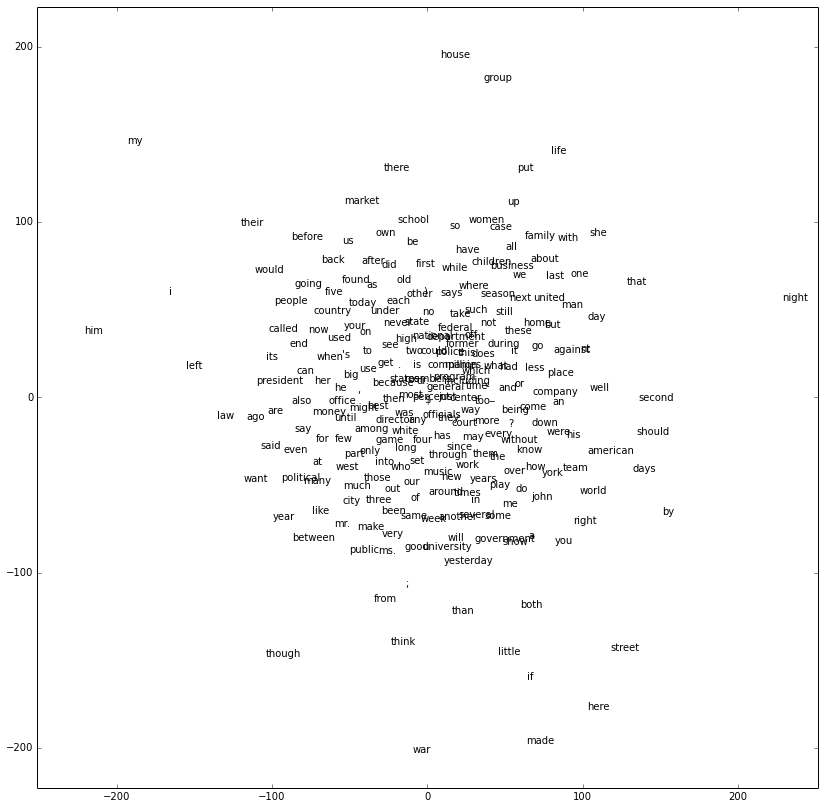

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
fig.set_figwidth(14)
fig.set_figheight(14)
ax = plt.axes()
ax.set_xlim(np.max(np.abs(tsne_embeddings[:,0]))*np.array([-1.1,1.1]))
ax.set_ylim(np.max(np.abs(tsne_embeddings[:,1]))*np.array([-1.1,1.1]))
for i, word in enumerate(list(model['vocab'])):
    ax.text(tsne_embeddings[i,0],tsne_embeddings[i,1],word)
plt.show()